In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Preparing the dataset


In [194]:
! ls ../dat

FaceEmbeddingsDataset.p  Labels.p


In [195]:
import pickle

In [196]:
with open("../dat/FaceEmbeddingsDataset.p", "rb") as f:
    d = pickle.load(f)

In [197]:
len(d), type(d[0]), len(d[0])

(400, list, 30)

In [198]:
videos = []
has_any = []

for si, sample in enumerate(d):
    mtx = [r[0] for r in sample if r]
    if mtx:
        videos.append(np.stack(mtx))
        has_any.append(si)

In [199]:
len(has_any)

381

In [200]:
with open("../dat/Labels.p", "rb") as f:
    labels = pickle.load(f)

In [201]:
labels = (np.array(labels) == 'FAKE').astype(int)

In [202]:
labels = labels[has_any]

In [203]:
len(videos), len(labels)

(381, 381)

In [204]:
for vi in range(len(videos)):
    missing = (30 - len(videos[vi]))
    if missing > 0:
        extra = np.zeros((missing, 128))
        row = np.concatenate((videos[vi], extra))
        videos[vi] = row

In [205]:
y[200:].float().mean()

tensor(nan)

In [206]:
X = torch.from_numpy(np.stack(videos)).float()[200:]
y = torch.from_numpy(labels).long()[200:]

In [207]:
all_idx = np.arange(len(X))
np.random.shuffle(all_idx)
dev_idx = all_idx[:70]
train_idx = all_idx[70:]
train_X = X[train_idx]
train_y = y[train_idx]
dev_X = X[dev_idx]
dev_y = y[dev_idx]

In [208]:
dev_y

tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [209]:
class BatchedIterator:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
    
    def iterate_once(self):
        for start in range(0, len(self.X), self.batch_size):
            end = start + self.batch_size
            yield self.X[start:end], self.y[start:end]

Testing the iterator:

In [210]:
train_iter = BatchedIterator(train_X, train_y, 303)

for batch in train_iter.iterate_once():
    print(batch[0].size(), batch[1].size())

torch.Size([111, 30, 128]) torch.Size([111])


# Neural network

## Definition

In [212]:
class SimpleFakeClassifier(nn.Module):
    def __init__(self, n_layer, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(128, hidden_dim, num_layers=n_layer, bidirectional=True, batch_first=True, dropout=0.2)
        self.output_layer = nn.Linear(2*hidden_dim, 2)
        
    def forward(self, X):
        _, (h, c) = self.lstm(X)
        h = torch.cat((h[-1], h[-2]), -1)
        return self.output_layer(h)
    
class SimpleFakeCNNClassifier(nn.Module):
    def __init__(self, filt1, filt2):
        super().__init__()
        #TODO
        self.conv1 = nn.Conv2d(128, filt1)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d()
        #self.output_layer = nn.Linear(, 2)
        
    def forward(self, X):
        # todo
        pass

## Model instance

In [213]:
model = SimpleFakeClassifier(
    hidden_dim=500,
    n_layer=1
)
model

/homes/gws/jacs/miniconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


SimpleFakeClassifier(
  (lstm): LSTM(128, 500, batch_first=True, dropout=0.2, bidirectional=True)
  (output_layer): Linear(in_features=1000, out_features=2, bias=True)
)

In [214]:
for n, p in model.named_parameters():
    print(n, p.size())

lstm.weight_ih_l0 torch.Size([2000, 128])
lstm.weight_hh_l0 torch.Size([2000, 500])
lstm.bias_ih_l0 torch.Size([2000])
lstm.bias_hh_l0 torch.Size([2000])
lstm.weight_ih_l0_reverse torch.Size([2000, 128])
lstm.weight_hh_l0_reverse torch.Size([2000, 500])
lstm.bias_ih_l0_reverse torch.Size([2000])
lstm.bias_hh_l0_reverse torch.Size([2000])
output_layer.weight torch.Size([2, 1000])
output_layer.bias torch.Size([2])


## Loss function and optimizer

In [215]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Sanity check

The model should perform close to random at this point.

**Note** we compute accuracy manually. Make sure you understand it.

In [216]:
dev_X.dtype

torch.float32

In [217]:
dev_pred = model(dev_X).max(axis=1)[1]
dev_acc = torch.eq(dev_pred, dev_y).sum().float() / len(dev_X)
dev_acc

tensor(0.4000)

## Training loop

In [218]:
batch_size = 50
train_iter = BatchedIterator(train_X, train_y, batch_size)
dev_iter = BatchedIterator(dev_X, dev_y, batch_size)

all_train_loss = []
all_dev_loss = []
all_train_acc = []
all_dev_acc = []

n_epochs = 100
for epoch in range(n_epochs):
    # training loop
    for bi, (batch_x, batch_y) in enumerate(train_iter.iterate_once()):
        
        y_out = model(batch_x)
        loss = criterion(y_out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # one train epoch finished, evaluate on the train and the dev set (NOT the test)
    train_out = model(train_X)
    train_loss = criterion(train_out, train_y)
    all_train_loss.append(train_loss.item())
    train_pred = train_out.max(axis=1)[1]
    train_acc = torch.eq(train_pred, train_y).sum().float() / len(train_X)
    all_train_acc.append(train_acc)
    
    dev_out = model(dev_X)
    dev_loss = criterion(dev_out, dev_y)
    all_dev_loss.append(dev_loss.item())
    dev_pred = dev_out.max(axis=1)[1]
    dev_acc = torch.eq(dev_pred, dev_y).sum().float() / len(dev_X)
    all_dev_acc.append(dev_acc)
    
    #print(f"Epoch: {epoch}\n  train accuracy: {train_acc}  train loss: {train_loss}")
    #print(f"  dev accuracy: {dev_acc}  dev loss: {dev_loss}")

## Dev accuarcy

In [219]:
dev_pred = model(dev_X).max(axis=1)[1]
dev_acc = torch.eq(dev_pred, dev_y).sum().float() / len(dev_X)
print(dev_acc)

import pandas as pd
s = pd.DataFrame(zip(list(dev_y.data.numpy()), list(dev_pred.data.numpy())), columns=['reference', 'prediction'])
s.groupby(['reference', 'prediction']).size().unstack()

tensor(0.8571)


prediction,0,1
reference,,
0,26,2
1,8,34


# Train accuracy

In [220]:
train_pred = model(train_X).max(axis=1)[1]
train_acc = torch.eq(train_pred, train_y).sum().float() / len(train_X)
print(train_acc)

import pandas as pd
s = pd.DataFrame(zip(list(train_y.data.numpy()), list(train_pred.data.numpy())), columns=['reference', 'prediction'])
s.groupby(['reference', 'prediction']).size().unstack()

tensor(0.9459)


prediction,0,1
reference,,
0,46,2
1,4,59


## Plot loss functions, accuracies

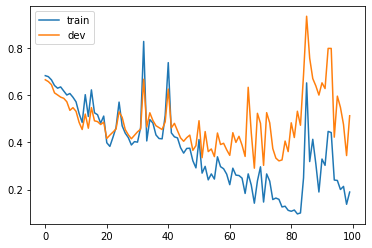

In [221]:
plt.plot(all_train_loss, label='train')
plt.plot(all_dev_loss, label='dev')
plt.legend()

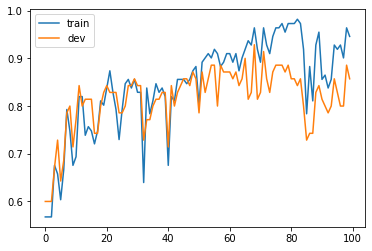

In [222]:
plt.plot(all_train_acc, label='train')
plt.plot(all_dev_acc, label='dev')
plt.legend()

# Using the GPU

In [223]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


Moving things manually to the GPU:

1. model: move once
1. criterion: move once
1. data: move one batch at a time

This should be automatically handled by your code the following way:

In [ ]:
if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()